In [1]:
import torch
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt

np.warnings.filterwarnings('ignore')

In [2]:
def f0(P, q, x):
    return .5 * x.T @ P @ x + q.T @ x

def f(A, b, x):
    return A @ x - b

In [3]:
def global_optimum(P, q):
    return -torch.inverse(P) @ q

def check_optimality(P, q, A, b, x, eps, step=1e-5):
    m, n = A.shape
    f0x = f0(P, q, x)
    for i in range(n):
        y = x.clone()
        y[i] += eps
        f0y = f0(P, q, y)
        if (f(A, b, y) <= 0).all() and f0y < f0x - eps:
            return False
    return True

In [4]:
def find_strict_feasible_point(A, b):
    m, n = A.shape
    e = 1 + torch.randn(m) ** 2
    x = torch.inverse(A.T @ A + 1e-3 * torch.eye(n)) @ A.T @ (b - e)
    assert (f(A, b, x) <= 0).all()
    return x

In [5]:
def random_positive_matrix(n):
    U = scs.ortho_group.rvs(n)
    D = np.diag(1 + np.random.randn(n) ** 2)
    return torch.tensor(U.T @ D @ U, dtype=torch.float32)

def random_lcqp(n, m):
    P = random_positive_matrix(n)
    q = torch.randn(n)
    A = torch.randn(m, n)
    b = torch.randn(m)
    return P, q, A, b

def global_optimum(P, q):
    return -torch.inverse(P) @ q

In [6]:
def print_report(P, q, A, b, x, name):
    print('f(', name, ') =', f0(P, q, x).item())
    print(name, '' if (f(A, b, x) <= 0).all() else 'does not', 'satisfy constraints')
    print('max(A @', name, '- b)', f(A, b, x).max())
    print(name, 'is', '' if check_optimality(P, q, A, b, x, 1e-5) else 'not', 'optimal')

In [7]:
P, q, A, b = random_lcqp(100, 60)
x0 = find_strict_feasible_point(A, b)

x_global = global_optimum(P, q)
print_report(P, q, A, b, x_global, 'x_global')

f( x_global ) = -35.7507209777832
x_global does not satisfy constraints
max(A @ x_global - b) tensor(15.0165)
x_global is  optimal


# Barrier method

In [8]:
def solve_LCQP_barrier(P, q, A, b, x0, t0, mu, alpha, beta, eps, eps_newton):
    m, n = A.shape
    x, t = x0, t0

    def f0(x):
        return .5 * x.T @ P @ x + q.T @ x

    def f(x):
        return A @ x - b

    def I_neg(u):
        return -torch.log(-u)

    def F(x):
        return t * f0(x) + I_neg(f(x)).sum()

    gaps = []
    while True:
        # Centering step via Newton method
        while True:
            d = -1 / f(x)

            # compute gradient and hessian at current point x
            g = t * (P @ x + q) + A.T @ d
            H = t * P + A.T @ torch.diag(d ** 2) @ A
            H_inv = torch.inverse(H)

            # compute step direction
            delta_x = -H_inv @ g

            # compute Newton decrement
            lambda_square = -g.T @ delta_x

            # stopping criteria for Newton method
            if lambda_square / 2 <= eps_newton:
                break

            # adjust step size via backtracking line search
            s = 1
            Fx = F(x)
            while True:
                x_next = x + s * delta_x
                Fx_next = F(x_next)
                
                # stopping criteria for line search
                if Fx_next <= Fx + alpha * s * g.T @ delta_x:
                    break

                s *= beta

            # perform Newton method step
            x = x_next
            gaps.append(m / t)

        # stopping criteria for barrier method
        if m / t < eps:
            break

        t = mu * t
    
    return x, gaps

t0=1, mu=2, alpha=0.05, beta=0.5
f( x ) = -24.03110694885254
x  satisfy constraints
max(A @ x - b) tensor(-2.6226e-06)
x is  optimal

t0=1, mu=4, alpha=0.05, beta=0.5
f( x ) = -24.03110122680664
x  satisfy constraints
max(A @ x - b) tensor(-2.8610e-06)
x is  optimal

t0=1, mu=8, alpha=0.05, beta=0.5
f( x ) = -24.031124114990234
x  satisfy constraints
max(A @ x - b) tensor(-3.7253e-07)
x is  optimal


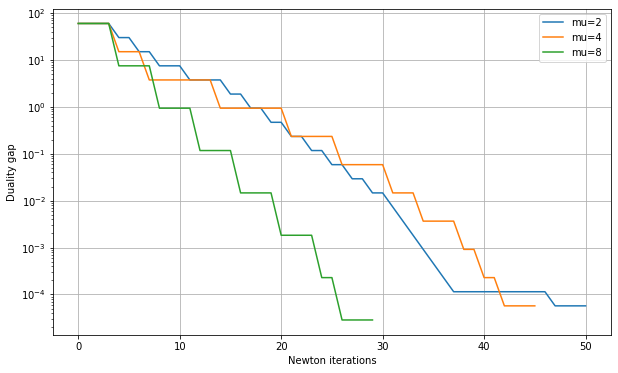

In [9]:
plt.figure(figsize=[10, 6])

print('t0=1, mu=2, alpha=0.05, beta=0.5')
x, gaps = solve_LCQP_barrier(P, q, A, b, x0, t0=1, mu=2, alpha=0.05, beta=0.5, eps=1e-4, eps_newton=1e-1)
plt.plot(gaps, label='mu=2')
print_report(P, q, A, b, x, 'x')
print()

print('t0=1, mu=4, alpha=0.05, beta=0.5')
x, gaps = solve_LCQP_barrier(P, q, A, b, x0, t0=1, mu=4, alpha=0.05, beta=0.5, eps=1e-4, eps_newton=1e-1)
plt.plot(gaps, label='mu=4')
print_report(P, q, A, b, x, 'x')
print()

print('t0=1, mu=8, alpha=0.05, beta=0.5')
x, gaps = solve_LCQP_barrier(P, q, A, b, x0, t0=1, mu=8, alpha=0.05, beta=0.5, eps=1e-4, eps_newton=1e-1)
plt.plot(gaps, label='mu=8')
print_report(P, q, A, b, x, 'x')

plt.yscale('log')
plt.xlabel('Newton iterations')
plt.ylabel('Duality gap')
plt.grid()
plt.legend()

# Primal-dual method

In [10]:
def solve_LCQP_primal_dual(P, q, A, b, x0, lmb0, mu, alpha, beta, eps, eps_feas):
    m, n = A.shape
    
    x, lmb = x0, lmb0
    
    def f0(x):
        return .5 * x.T @ P @ x + q.T @ x
    
    def f(x):
        return A @ x - b
    
    def surrogate_duality_gap():
        return -f(x).T @ lmb
    
    def r_t(x, lmb):
        r_dual = P @ x + q + A.T @ lmb
        r_cent = -torch.diag(lmb) @ f(x) - 1 / t
        r_feas = torch.cat([r_dual, r_cent])
        return r_feas
    
    r_norms, gaps = [], []
    while True:
        # compute primal-dual search direction
        
        gap = surrogate_duality_gap()
        t = mu * m / gap
        r = r_t(x, lmb)
        r_norm = torch.norm(r)
        
        r_norms.append(r_norm)
        gaps.append(gap)
        
        if r_norm <= eps_feas and gap <= eps:
            break
            
        y = torch.cat([x, lmb])
        M = torch.cat([
            torch.cat([                   P,               A.T], dim=1),
            torch.cat([-torch.diag(lmb) @ A, -torch.diag(f(x))], dim=1)
        ], dim=0)
        
        delta_y = -torch.inverse(M) @ r
        delta_x, delta_lmb = delta_y[:n], delta_y[n:]
        
        # line search
        s_max = min(1, (-lmb / delta_lmb)[delta_lmb < 0].min())
        s = 0.99 * s_max
        while True:
            x_next = x + s * delta_x
            lmb_next = lmb + s * delta_lmb
            r_next = r_t(x_next, lmb_next)
            if (f(x_next) < 0).all() and torch.norm(r_next) <= (1 - alpha * s) * r_norm:
                break
            s *= beta
        
        x = x_next
        lmb = lmb_next
    
    return x, r_norms, gaps

f( x_global ) = -35.7507209777832
x_global does not satisfy constraints
max(A @ x_global - b) tensor(15.0165)
x_global is  optimal

mu=2, alpha=0.05, beta=0.5
f( x ) = -24.03110122680664
x  satisfy constraints
max(A @ x - b) tensor(-2.6226e-06)
x is  optimal

mu=10, alpha=0.05, beta=0.5
f( x ) = -24.03110122680664
x  satisfy constraints
max(A @ x - b) tensor(-2.3842e-06)
x is  optimal

mu=100, alpha=0.05, beta=0.5
f( x ) = -24.03110122680664
x  satisfy constraints
max(A @ x - b) tensor(-2.6822e-07)
x is  optimal



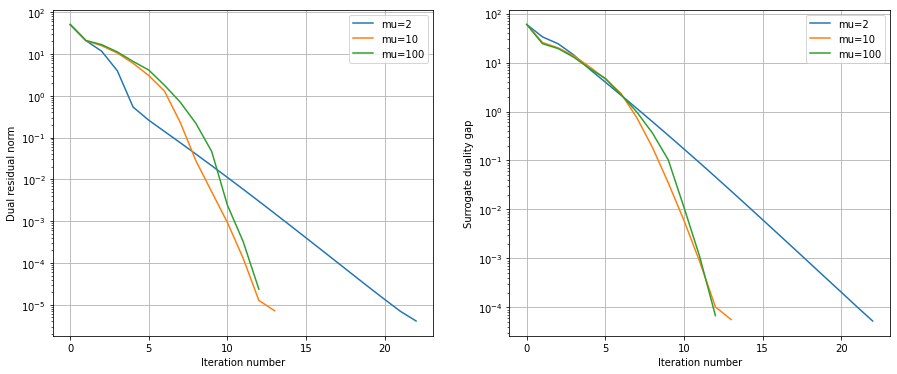

In [11]:
plt.figure(figsize=[15, 6])

lmb0 = -1 / f(A, b, x0)

x_global = global_optimum(P, q)
print_report(P, q, A, b, x_global, 'x_global')
print()

print('mu=2, alpha=0.05, beta=0.5')
x, r_norms, gaps = solve_LCQP_primal_dual(P, q, A, b, x0, lmb0, mu=2, alpha=0.05, beta=0.5, eps=1e-4, eps_feas=1e-4)
plt.subplot(1, 2, 1); plt.plot(r_norms, label='mu=2')
plt.subplot(1, 2, 2); plt.plot(gaps, label='mu=2')
print_report(P, q, A, b, x, 'x')
print()

print('mu=10, alpha=0.05, beta=0.5')
x, r_norms, gaps = solve_LCQP_primal_dual(P, q, A, b, x0, lmb0, mu=10, alpha=0.05, beta=0.5, eps=1e-4, eps_feas=1e-4)
plt.subplot(1, 2, 1); plt.plot(r_norms, label='mu=10')
plt.subplot(1, 2, 2); plt.plot(gaps, label='mu=10')
print_report(P, q, A, b, x, 'x')
print()

print('mu=100, alpha=0.05, beta=0.5')
x, r_norms, gaps = solve_LCQP_primal_dual(P, q, A, b, x0, lmb0, mu=100, alpha=0.05, beta=0.5, eps=1e-4, eps_feas=1e-4)
plt.subplot(1, 2, 1); plt.plot(r_norms, label='mu=100')
plt.subplot(1, 2, 2); plt.plot(gaps, label='mu=100')
print_report(P, q, A, b, x, 'x')
print()

plt.subplot(1, 2, 1)
plt.yscale('log')
plt.xlabel('Iteration number')
plt.ylabel('Dual residual norm')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.xlabel('Iteration number')
plt.ylabel('Surrogate duality gap')
plt.grid()
plt.legend()